# Zach's Karate Club

In this notebook we will use the Zach Karate graph to learn about graph nueral networks (GNNs), and use one to do binary classification on our graph.

In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
from torch.nn import Linear, ReLU, Softmax, Sigmoid, CrossEntropyLoss, Tanh
from torch.optim import Adam
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import KarateClub
from torch_geometric.nn import Sequential, GCNConv, JumpingKnowledge
from torch_geometric.nn import global_mean_pool
import typing as T

## EDA

In [65]:
G = KarateClub()
data = G[0]

In [80]:
data.x

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [68]:
G.num_classes, G.num_features

(4, 34)

In [44]:
nx_G = to_networkx(data, to_undirected=True)

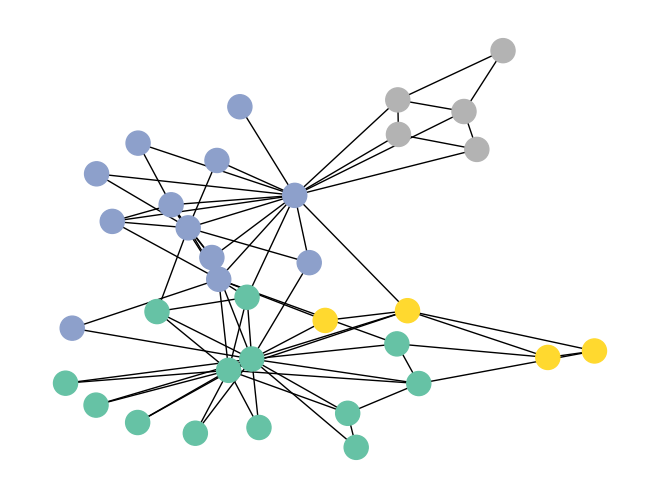

In [46]:
nx.draw(nx_G, pos=nx.spring_layout(nx_G, seed=42),
                 with_labels=False,
                 node_color=data.y,
                 cmap="Set2")

In [58]:
G[0].y

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

## Building the Model

In [271]:
class KarateGCN(nn.Module):
    
    def __init__(self, num_classes: int, softmax: bool = False):
        super(KarateGCN, self).__init__()
        torch.manual_seed(42)
        self.softmax = softmax
        self.model = Sequential(
            "x, edge_index",
            [(GCNConv(G.num_features, 17),'x, edge_index -> x1'),
             ReLU(inplace=True),
            (GCNConv(17, 10),'x1, edge_index -> x2'),
            ReLU(inplace=True),
            # (lambda x1, x2: [x1, x2], 'x1, x2 -> xs'),
            # (JumpingKnowledge("cat", 10, num_layers=num_layers), 'xs -> x'),
            Linear(10, num_classes)])
    

    def forward(self, data):
        out = self.model(data.x, data.edge_index)
        if self.softmax:
            return Softmax(dim=1)(out)
        return out
        

In [280]:
model = KarateGCN(G.num_classes)

In [281]:
print(model)

KarateGCN(
  (model): Sequential(
    (0) - GCNConv(34, 17): x, edge_index -> x1
    (1) - ReLU(inplace=True): x1 -> x1
    (2) - GCNConv(17, 10): x1, edge_index -> x2
    (3) - ReLU(inplace=True): x2 -> x2
    (4) - Linear(in_features=10, out_features=4, bias=True): x2 -> x2
  )
)


In [262]:
def train(data: KarateClub, 
          model: nn.Module, 
          num_epochs: int, 
          criterion=None, 
          optimizer=None) -> float:

    def fpass(data: KarateClub, criterion, optimizer) -> T.Tuple:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        return loss

    losses = []
    criterion = CrossEntropyLoss() if criterion is None else criterion
    optimizer = Adam(model.parameters(), lr=0.01) if optimizer is None else optimizer
    for _ in range(num_epochs):
        loss = fpass(data, criterion, optimizer)
        losses.append(loss.item())
    return losses

In [282]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
G = G.to(device)

In [283]:
losses = train(data=G, model=model, num_epochs=100)

In [250]:
def plot(losses):
    plt.title("Losses over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.plot(losses, marker='o')
    plt.show()

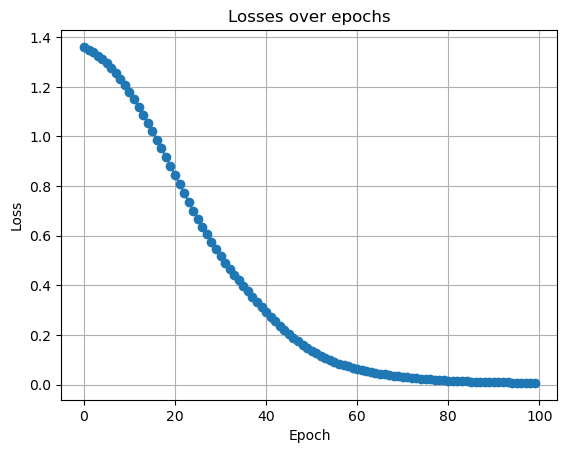

In [284]:
plot(losses)

In [273]:
model_w_softmx = KarateGCN(G.num_classes, softmax=True)

In [285]:
losses_w_s = train(data=G, model=model_w_softmx, num_epochs=100)

In [287]:
G.y

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

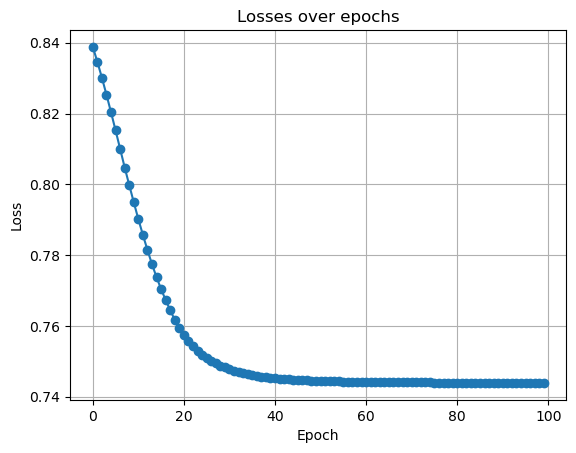

In [286]:
plot(losses_w_s)

## Model Two: Tanh

In [276]:
class KarateModel2(nn.Module):

    def __init__(self, num_classes: int, num_layers: int, softmax: bool = False):
        super(KarateModel2, self).__init__()
        torch.manual_seed(42)
        self.softmax = softmax
        self.model = Sequential(
            "x, edge_index",
            [(GCNConv(G.num_features, 17),'x, edge_index -> x1'),
             Tanh(),
            (GCNConv(17, 10),'x1, edge_index -> x2'),
            Tanh(),
            Linear(10, num_classes)])
    
    def forward(self, data):
        out = self.model(data.x, data.edge_index)
        if self.softmax:
            return Softmax(dim=1)(out)
        return out

In [256]:
model2 = KarateModel2(G.num_classes, num_layers=4)
model2.to(device)

KarateModel2(
  (model): Sequential(
    (0) - GCNConv(34, 17): x, edge_index -> x1
    (1) - Tanh(): x1 -> x1
    (2) - GCNConv(17, 10): x1, edge_index -> x2
    (3) - Tanh(): x2 -> x2
    (4) - Linear(in_features=10, out_features=4, bias=True): x2 -> x2
  )
)

In [257]:
losses2 = train(data=G, model=model2, num_epochs=100)

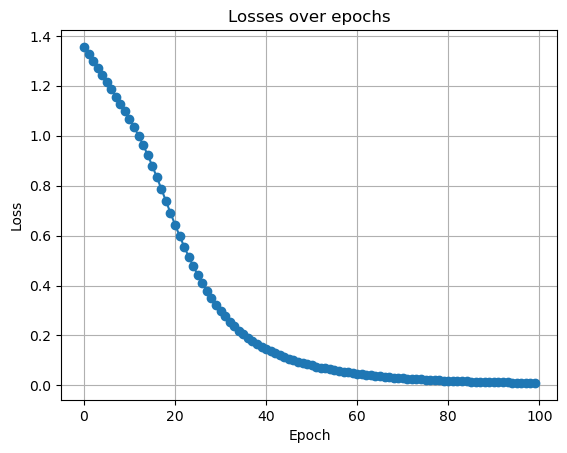

In [258]:
plot(losses2)

In [268]:
model2_w_softmax = KarateModel2(G.num_classes, num_layers=4, softmax=True)

In [269]:
losses2_w_s = train(data=G, model=model2_w_softmax, num_epochs=100)

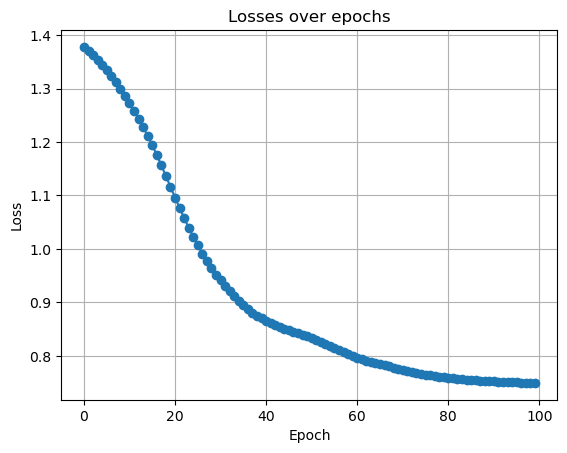

In [270]:
plot(losses2_w_s)

## Why Shouldn't We Use Softmax as a final activation?

Duh, we haven't one hot encoded the target 